In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
import torchvision.transforms as transforms
import tqdm
import pathlib
from project.utils import *
from project.models.TIMM import TimmModel
from functools import partial


%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
exp = 0
dataset = "CIFAR10"
device = "cuda"
root_path = pathlib.Path('H:/arty/data/IT-GAN') 
data_path = root_path / 'data' 
checkpoint_path = root_path / 'checkpoints' 
weight_path = checkpoint_path / f"G_Pretrained_{dataset}_exp{exp}.pth"
dim_z=128
samples_per_class = 1
metric = 'itgan'
batch_size = 256
num_workers = 4
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
shuffle = True

In [4]:
data = get_dataset(dataset, data_path, None)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
config = {
    'dim_z': 128,  
    'resolution': 32,
    'G_attn': '0', 
    'n_classes': data['num_classes'],
    'G_shared': False, 
}
train_data = {
    'ITGAN': GeneratorDatasetLoader(*load_anchors(checkpoint_path / f'ITGAN_{dataset}_exp{exp}.pt'), weight_path, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size,  device=device),
    'GAN_Inversion': GeneratorDatasetLoader(*load_anchors(checkpoint_path / f'GAN_Inversion_{dataset}_exp{exp}.pt'), weight_path, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size,  device=device),
    'GAN': GeneratorDatasetLoader(torch.randn(len(data['train']), dim_z), data['label_train'], 'BigGAN', config, weight_path, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size, device=device), 
    'real': DeviceDataLoader(data['train'], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, device=device),
}

d = next(iter(train_data['ITGAN']))


In [6]:
def set_transforms(model, mode, loader, eval, pretrained=True):
    if pretrained:
        eval.set_transform(model.transform)
        if mode == 'real':
            loader.set_transform(torchvision.transforms.Compose(model.transform.transforms))
        else:
            loader.set_transform(torchvision.transforms.Compose([t for t in model.transform.transforms if not isinstance(t, transforms.ToTensor)])) 
    else:
        eval.set_transform(torchvision.transforms.Compose([transforms.ToTensor()] + [t for t in model.transform.transforms if isinstance(t, transforms.Normalize)]))
        if mode == 'real':
            loader.set_transform(torchvision.transforms.Compose([transforms.ToTensor()] + [t for t in model.transform.transforms if isinstance(t, transforms.Normalize)]))
        else:
            loader.set_transform(torchvision.transforms.Compose([t for t in model.transform.transforms if isinstance(t, transforms.Normalize)]))
            # loader.set_transform(None)

In [7]:
param_diffaug = ParamDiffAug()
aug = partial(diff_augment, strategy='color_crop_cutout_flip_scale_rotate', param=param_diffaug)
epochs = 32
lr = 0.001
wd = 0.0005
drop_rate = 0.1
eval_data = DeviceDataLoader(data['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers, device=device)
pretrained=True
test_accs_dict = {mode: [] for mode in train_data}
train_accs_dict = {mode: [] for mode in train_data}
model_dict  = {}
model_name = "resnet18.a1_in1k"

In [7]:
for mode, loader in train_data.items():
    print(f"Training {mode}")
    model = TimmModel(model_name, data['num_classes'], drop_rate=drop_rate, pretrained=pretrained).to(device)
    model.encoder_grad(not pretrained)
    model.head_grad(True)
    set_transforms(model, mode, loader, eval_data, pretrained)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=len(loader)*epochs)
    scaler = torch.cuda.amp.GradScaler()
    train_acc = 0
    test_acc = 0
    loss_sum = 0
    epoch_iter = tqdm.trange(epochs, desc=mode)
    for epoch in epoch_iter:
        train_acc_tmp = 0
        loss_sum_tmp = 0
        if epoch == epochs//5:
            model.encoder_grad(True)
        epoch_iter.set_description(f"{mode} - training")
        model.train()
        for i, (x, y) in enumerate(loader):
            epoch_iter.set_postfix(step=f"{100*(i+1)/len(loader):.1f}%", test_acc=f"{test_acc*100:.1f}%", train_acc=f"{train_acc*100:.1f}%", loss=loss_sum)
            x = aug(x)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                y_hat = model(x)
                loss = criterion(y_hat, y)
            train_acc_tmp += (y_hat.argmax(-1) == y).float().sum().item()
            loss_sum_tmp += loss.item()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            # lr_scheduler.step()
        train_acc = train_acc_tmp / len(loader.dataset)
        train_accs_dict[mode].append(train_acc)
        loss_sum = loss_sum_tmp / len(loader)

        epoch_iter.set_description(f"{mode} - evaluating")
        model.eval()
        for x, y in eval_data:
            with torch.no_grad():
                y_hat = model(x)
                test_acc += (y_hat.argmax(-1) == y).float().sum().item()
        test_acc /= len(eval_data.dataset)
        test_accs_dict[mode].append(test_acc)
        
        test_acc=test_accs_dict[mode][-1]
    epoch_iter.set_description(f"{mode} - Done")
    epoch_iter.set_postfix(step=f"{100*(i+1)/len(loader):.1f}%", test_acc=f"{test_acc*100:.1f}%", train_acc=f"{train_acc*100:.1f}%", loss=loss_sum)
    model_dict[mode] = checkpoint_path / f"{model.name}_{mode}_{dataset}_exp{exp}_acc{int(test_acc*100)}.pth"
    torch.save({
        "name" : model.name,
        "state_dict": model.state_dict(),
        "test_acc" : test_accs_dict[mode],
        "train_acc" : train_accs_dict[mode],
        "mode" : mode,
        "exp" : exp,
        "dataset" : dataset,
        "pretrained" : pretrained,
        "epochs" : epochs,
        "lr" : lr,
        "wd" : wd,
        "drop_rate" : drop_rate,
    }, 
    model_dict[mode])


Training ITGAN


AttributeError: module 'torch.optim' has no attribute 'Adam16'

In [ ]:
model_dict

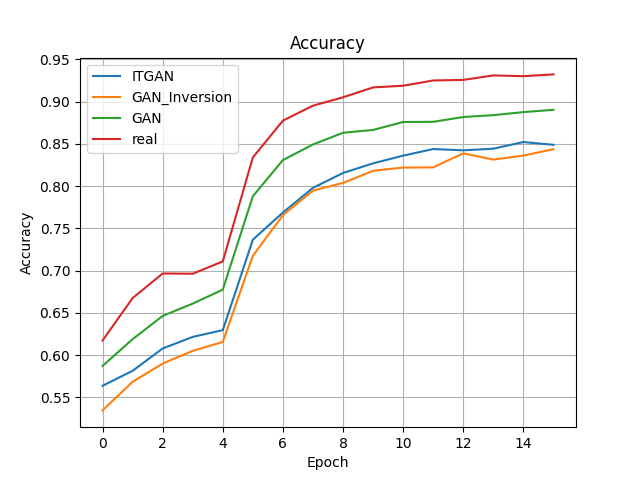

In [ ]:
fig, ax = plt.subplots()
for mode, data in model_dict.items():
    state = torch.load(data)
    ax.plot(state['test_acc'], label=mode+"_test")
    ax.plot(state['train_acc'], label=model+"_train")
ax.legend()
ax.set_title("Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.grid()
plt.show()


In [8]:
saved_model_dict = {
            'ITGAN': 'H:/arty/data/IT-GAN/checkpoints/resnet18.a1_in1k_ITGAN_CIFAR10_exp0_acc84.pth',
            'GAN_Inversion': 'H:/arty/data/IT-GAN/checkpoints/resnet18.a1_in1k_GAN_Inversion_CIFAR10_exp0_acc84.pth',
            'GAN': 'H:/arty/data/IT-GAN/checkpoints/resnet18.a1_in1k_GAN_CIFAR10_exp0_acc89.pth',
            'real': 'H:/arty/data/IT-GAN/checkpoints/resnet18.a1_in1k_real_CIFAR10_exp0_acc93.pth'}

In [9]:
lr_z = 0.01
wd_z = 0.0
lr_c = 0.0001
wd_c = 0.0
mode = 'GAN'
shuffle = False
criterion = nn.CrossEntropyLoss()
classifier = TimmModel(model_name, data['num_classes'], drop_rate=drop_rate, pretrained=False).to(device)
classifier_control = TimmModel(model_name, data['num_classes'], drop_rate=drop_rate, pretrained=False).to(device)

classifier.load_state_dict(torch.load(saved_model_dict[mode])['state_dict'])
classifier_control.load_state_dict(torch.load(saved_model_dict[mode])['state_dict'])
classifier.to(device)
classifier_control.to(device)

optimizer_classifier = torch.optim.Adam(classifier.parameters(), lr=lr_c, weight_decay=wd_c)
optimizer_control = torch.optim.Adam(classifier_control.parameters(), lr=lr_c, weight_decay=wd_c)
generator_control = train_data[mode]
generator = GeneratorDatasetLoader(generator_control.anchors.detach().clone(), generator_control.labels.detach().clone(), 'BigGAN', config, weight_path, shuffle=shuffle, num_workers=0, batch_size=batch_size, device=device)
imgs = []
learnable = [generator.anchors]
for p in learnable:
    p.requires_grad = True
    print(p.shape, p.requires_grad, p.device)
optimizer_z = torch.optim.Adam(learnable, lr=lr_z, weight_decay=wd_z)

set_transforms(classifier, mode, generator, eval_data, pretrained=pretrained)
set_transforms(classifier_control, mode, generator_control, eval_data, pretrained=pretrained)

imgs = []
iterations = 10
every = 1
accs_tune = {mode: [], 
             mode+"_control": []}
loss = []
loss2 = []
loss_z = []

def eval_classifier(classifier, eval_data):
    test_acc = 0
    classifier.eval()
    for x, y in tqdm.tqdm(eval_data, desc="eval"):
        with torch.no_grad():
            y_hat = classifier(x)
            test_acc += (y_hat.argmax(-1) == y).float().sum().item()
            # break
    test_acc /= len(eval_data.dataset)
    classifier.train()
    return test_acc

for i in range(iterations):
    if i % every == 0:
        test_acc = eval_classifier(classifier, eval_data)
        test_acc2 = eval_classifier(classifier_control, eval_data)
        accs_tune[mode].append(test_acc)
        accs_tune[mode+"_control"].append(test_acc2)
        if len(loss) > 0:
            print(f"test_acc: {test_acc}, test_acc_base: {test_acc2}, loss: {np.mean(loss)}, loss2: {np.mean(loss2)}")
        else:
            print(f"test_acc: {test_acc}, test_acc_base: {test_acc2}")

    optimizer_z.zero_grad()
    for i, (x, y) in enumerate(tqdm.tqdm(generator, desc="z")):
        if i == 0:
            imgs.append(x.detach().clone().cpu())
        y_hat = classifier(x)
        z_loss = -criterion(y_hat, y) 
        loss_z.append(z_loss.item())
        z_loss.backward()
        optimizer_z.step()
        optimizer_z.zero_grad()
        # break
    
    #stage 2
    for i, (x, y) in enumerate(tqdm.tqdm(generator, desc="c1")):
        if i == 0:
            imgs.append(x.detach().clone().cpu())
        optimizer_classifier.zero_grad()
        x = aug(x)
        y_hat = classifier(x)
        c_loss = criterion(y_hat, y)
        loss.append(c_loss.item())
        c_loss.backward()
        optimizer_classifier.step()
        # break

    #control group
    for x, y in tqdm.tqdm(generator_control, desc="c2"):
        optimizer_control.zero_grad()
        x = aug(x)
        y_hat = classifier_control(x)
        c_loss = criterion(y_hat, y)
        loss2.append(c_loss.item())
        c_loss.backward()
        optimizer_control.step()
        # break
        
    
else:
    test_acc = eval_classifier(classifier, eval_data)
    test_acc2 = eval_classifier(classifier_control, eval_data)
    accs_tune[mode].append(test_acc)
    accs_tune[mode+"_control"].append(test_acc2)
    print(f"test_acc: {test_acc}, test_acc_base: {test_acc2}, loss: {np.mean(loss)}, loss2: {np.mean(loss2)}")

torch.Size([50000, 128]) True cpu


eval:   0%|          | 0/40 [00:08<?, ?it/s]


test_acc: 0.0228, test_acc_base: 0.0228


eval:   0%|          | 0/40 [00:09<?, ?it/s]


test_acc: 0.0228, test_acc_base: 0.0229, loss: 0.4195038676261902, loss2: 0.3540462851524353


eval:   0%|          | 0/40 [00:00<?, ?it/s]


KeyboardInterrupt: 

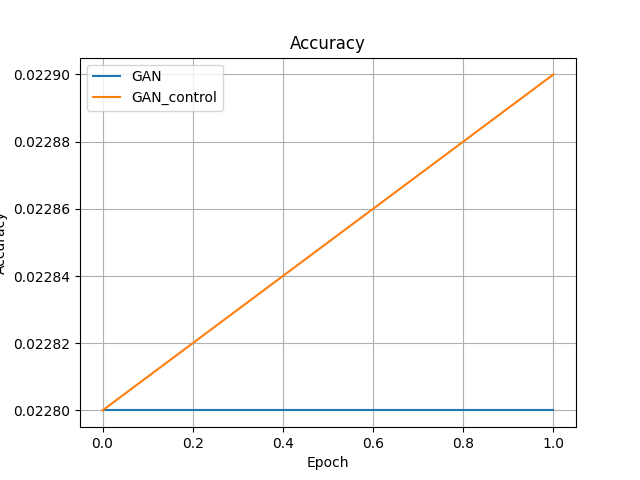

In [10]:
fig, ax = plt.subplots()
for mode, accs in accs_tune.items():
    ax.plot(accs, label=mode)
ax.legend()
ax.set_title("Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.grid()

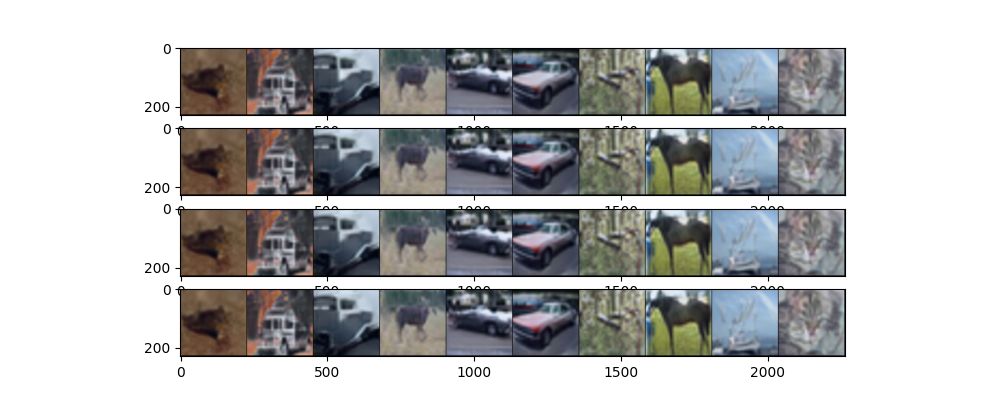

In [11]:
fig, ax = plt.subplots(len(imgs), 1, figsize=(10, len(imgs)))
for i in range(len(imgs)):
    grid = torchvision.utils.make_grid(imgs[i][:data["num_classes"]], nrow=data["num_classes"], normalize=True)
    ax[i].imshow(grid.permute(1, 2, 0))


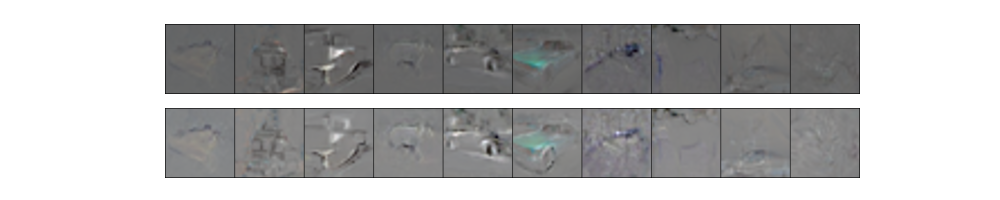

In [12]:
fig2, ax2 = plt.subplots(len(imgs)//2, 1, figsize=(10, len(imgs)//2))
for i in range(0, len(imgs), 2):
    grid = imgs[i] - imgs[i+1]
    grid = grid[:data["num_classes"]]
    grid = torchvision.utils.make_grid(grid, nrow=data["num_classes"], normalize=True)
    ax2[i//2].imshow(grid.permute(1, 2, 0))
    ax2[i//2].axis('off')

In [ ]:
classifier

TimmModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [ ]:
import timm

classifier3 = timm.create_model(model_name, pretrained=pretrained, num_classes=0)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])